# PhysicsNeMo Curator: Preparing Data for DoMINO Architecture

This Jupyter Notebook provides a guide and practical examples for using **PhysicsNeMo Curator** to prepare CFD simulation data for 
training with the **DoMINO architecture**. We will focus on processing **VTK (VTP, VTU)** and **STL input files**, 
and generating optimized datasets in **Zarr or NumPy format**. For this notebook we will use DrivAerML dataset hosted in 
```html
https://huggingface.co/datasets/neashton/drivaerml
```
we will explain how to download the dataset in the follwoing.

## Table of Contents

- [What is PhysicsNeMo Curator?](#1-what-is-physicsnemo-curator)
- [Working with Your CFD Data](#2-working-with-your-cfd-data)
- [Understanding the DoMINO Data Processing Pipeline](#3-understanding-the-domino-data-processing-pipeline)
- [Setting Up Your Environment and Download dataset](#4-setting-up-your-environment-and-download-dataset)
- [Curating Data for DoMINO](#5-curating-data-for-domino)
  - [Loading and Inspecting Input Data (Conceptual)](#51-loading-and-inspecting-input-data-conceptual)
  - [Configuring the ETL Pipeline](#52-configuring-the-etl-pipeline)
  - [Running the Curator](#53-running-the-curator)
- [Exploring the Output Data](#exploring-the-output-data)
- [Bounding Box Extraction for VTP Files](#Bounding_Box_Extraction_for_VTP_Files)
- [Dataset Field Analysis and Visualization](#dataset-field-analysis-and-visualization)
- [Conclusion](#conclusion)

---

## 1. What is PhysicsNeMo Curator?

**PhysicsNeMo Curator** is a powerful sub-module of the **PhysicsNeMo framework**, a Pythonic library designed to streamline and accelerate the crucial process of data curation for engineering and scientific datasets. It leverages **GPUs** to accelerate data extraction, transformation, and loading (ETL), making it highly efficient for large-scale datasets.

**Key features include:**

- **Customizable Interfaces and Pipelines**: Flexible tools for adapting to various data formats and schemas.
- **GPU Acceleration**: Significantly speeds up data processing.
- **Integration with PhysicsNeMo**: Designed to work seamlessly within the broader PhysicsNeMo framework for AI model training and inference.

This notebook demonstrates its use in the context of the **DoMINO architecture**, which is optimized for **automotive aerodynamics applications**.

---

## 2. Working with Your CFD Data

PhysicsNeMo Curator can process CFD simulation data from various solvers. This notebook focuses on the recommended approach of converting your CFD data into supported formats before curation.

**Currently Supported Formats for Input:**

- **VTK formats:**
  - `.vtu`: Volume mesh data
  - `.vtp`: Surface mesh data
- **STL**: Geometry files

This allows for a standardized input to the **DoMINO ETL pipeline**.

---

## 3. Understanding the DoMINO Data Processing Pipeline

The DoMINO ETL pipeline within PhysicsNeMo Curator is specifically designed to process **automotive aerodynamics simulation data** for machine learning training. It performs the following critical steps:

**Reads:**

- Geometry files (STL format)
- Volume mesh data (VTU format)
- Surface mesh data (VTP format)
- Flow field variables (e.g., pressure, velocity, turbulence)

It supports data from various sources like **DriveSim**, **DrivAerML**, and **AhmedML**.

**Transforms:**

- **Extracts and Normalizes**: Field variables such as pressure coefficients and wall shear stress.
- **Processes Geometry Data**: Handles coordinates, face connectivity, and areas.
- **Computes Derived Quantities**: Calculates reference values and other necessary metrics.
- **Applies Mesh Decimation (Optional)**: Reduces mesh complexity while preserving critical information.

**Outputs:**

- **Training-Ready Datasets**: Generates optimized datasets in either **NumPy** or **Zarr** format.
- **Efficient Data Loading**: Outputs are compressed and chunked for efficient model training.
- **Metadata Preservation**: Retains important metadata and processing parameters for reproducibility.

This comprehensive pipeline converts raw CFD outputs into datasets directly usable for AI model training in external aerodynamics.

---

## 4. Setting Up Your Environment and Download dataset

In this notebook, we will use the PhysicsNeMo container and install the PhysicsNeMo-Curator package inside it. Follow the steps below:
### 4.1 Setting Up Your Environment
```bash
# Pull the latest PhysicsNeMo container from NGC
docker pull nvcr.io/nvidia/physicsnemo/physicsnemo:25.06

# Clone the PhysicsNeMo-Curator repository
git clone https://github.com/NVIDIA/physicsnemo-curator.git
cd physicsnemo-curator

# Upgrade pip and install the curator in editable (development) mode
pip install --upgrade pip
pip install -e ".[dev]"

```
### 4.2 Download the DrivAer ML dataset 
Download the DrivAer ML dataset using the provided download_hugging_face_dataset.sh script:
```bash
# Download a few runs (1-5) to default directory
./download_hugging_face_dataset.sh

# Download specific runs to a custom directory
./download_hugging_face_dataset.sh -d ./my_data -s 1 -e 100

# Get help
./download_hugging_face_dataset.sh --help
```

## 5. Curating Data for DoMINO

Now, let's walk through the process of curating your data using **PhysicsNeMo Curator** for the **DoMINO architecture**.
**PhysicsNeMo Curator** accept CFD simulation data in multiple schemas/structures  DriveSim, DrivAerML, AhmedML. If you have data whith different schema, you might covnert your data into either of these schemas. 
As an example we provide for you a giud in this notebook to change your data schema into DrivAerML.

1- **DrivAerML schema**
```bash
run_1/
├── drivaer_1.stl                  # Geometry file
├── volume_1.vtu                   # Volume mesh data
└── boundary_1.vtp                 # Surface mesh data
```

2- **DriveSim schema** 

```bash
run_1/
├── body.stl                  # Geometry file
├── internal.vtu              # Volume mesh data
└── aero_suv.vtp              # Surface mesh data
```
you can define the data schema in `config/domino_etl.yaml` as:

```yaml
  common:
    kind: drivaerml  # must be either drivesim, drivaerml or ahmedml
```

### 5.1 Field Variables
1. **Surface Data**

Surface fields are non-dimensionalized by (density * stream_velocity^2):

    Pressure coefficient (Cp)
    Wall shear stress components

2. **Volume Data**

Fields are non-dimensionalized as follows:

    Velocity components (U): normalized by stream_velocity
    Pressure (p): normalized by (density * stream_velocity^2)
    Turbulent quantities (k, omega, etc.): normalized by (stream_velocity * length_scale)

Note: The variables of interest should be defined as the surface_variables and volume_variables as the configurations paramteres. See `config/variables/*.yaml` files for defining the variable names. 
For example:

```yaml
volume_variables:
  UMean: vector
  pMean: scalar
  nutMean: scalar

surface_variables:
  pMean: scalar
  wallShearStressMean: vector
```

3. **Reference Values**
    - stream_velocity: Free-stream velocity
    - density: Air density
    - length_scale: Characteristic length (maximum dimension of the geometry)

**These referecne paramters can be used for non-dimensionalizing the surface_variables and volume_variables. For more details, see the configuration examples in config/domino_etl.yaml.**


### 5.2 Loading and Inspecting Input Data (Conceptual)

While PhysicsNeMo Curator handles data loading internally based on the specified input directory, it's useful to understand the structure of the data it expects.

Imagine your input directory (`/data/my_cfd_sims/`) contains subdirectories for each simulation case, with `.vtp`, `.vtu`, and `.stl` files within them.

For example for DrivAerML Format, the dataset should contain at least the following files:

```bash
run_1/
├── drivaer_1.stl                  # Geometry file
├── volume_1.vtu                   # Volume mesh data
└── boundary_1.vtp                 # Surface mesh data
```

### 5.3 Configuring the ETL Pipeline

PhysicsNeMo Curator uses configuration files (often YAML-based) to define the ETL pipeline. The `domino_etl` configuration is pre-built for the DoMINO architecture. You primarily need to specify the **input** and **output** directories and the **model type**.

When running from the command line, these parameters are passed as arguments. In a Python environment (such as a Jupyter Notebook), you would typically interact with the Curator's API, often by loading or constructing a configuration.

**Parameters to configure:**

- `--config-name=domino_etl`: Specifies the pre-defined DoMINO ETL configuration.
- `etl.source.input_dir`: The directory containing your raw CFD data (`.vtp`, `.vtu`, `.stl` files).
- `etl.sink.output_dir`: The directory where the processed Zarr or NumPy data will be saved.
- `etl.common.model_type`: Specifies the type of data prepared for the model. For DoMINO, `surface` is used for surface-based predictions, `volume` for volume prediction and `combined` for surface and volume prediction.
-  `etl.sink.overwrite_existing`: can be either true (default) or false. When set to false, the Curator will not overwrite existing files. This is useful for incremental runs of the Curator.
-  `etl.common.model_type`: can be surface (default) or volume or combined. This option is used to specify the type of model that will be trained on the dataset.
-  Output format: To switch from Zarr (default) to NumPy, please use the `serialization_format=numpy` flag.


### 5.3 Running the Curator

Once your data is organized and the ETL configuration is defined, you can run the curator via:

#### **Command Line Interface (CLI)**

Example:

```bash
export PYTHONPATH=$PYTHONPATH:examples &&
physicsnemo-curator-etl                         \
    --config-dir=examples/config                \
    --config-name=domino_etl                    \
    etl.source.input_dir=/data/drivaerml/       \
    etl.sink.output_dir=/data/drivaerml.processed.surface \
    etl.common.model_type=combined \
    serialization_format=numpy
```

## 6. Exploring the Output Data
Once the Curator has finished processing, you can load and inspect the output data. Since the output can be either Zarr or NumPy, we'll show examples for both.

### 6.1 **Example: Loading Zarr Data**

Zarr is a format for chunked, compressed, N-dimensional arrays. It's excellent for large datasets as it allows for lazy loading and efficient access.

In [9]:
import os
import zarr

# Update to your actual Zarr data directory
output_data_dir = "/workspace/inst_dli/output_zarr"

# List all .zarr directories in the dataset
zarr_cases = [f for f in os.listdir(output_data_dir) if f.endswith(".zarr")]

if not zarr_cases:
    print(f"No Zarr directories found in {output_data_dir}")
else:
    # Pick the first case (or replace with a specific name)
        sample_case = sorted(zarr_cases)[0]
        case_path = os.path.join(output_data_dir, sample_case)
        print(f"\n Loading Zarr dataset: {case_path}")

        try:
            root = zarr.open(case_path, mode='r')
            print(f"Loaded '{case}' successfully!")

            print("  Top-level keys (arrays/groups):")
            for key in root.keys():
                item = root[key]
                if isinstance(item, zarr.hierarchy.Group):
                    print(f"  - {key}/ (group): {list(item.keys())}")
                else:
                    print(f"  - {key}: shape={item.shape}, dtype={item.dtype}")
#                    if item.ndim > 0:
#                        print(f"    First 5 values:\n    {item[:5]}")
#                    else:
#                        print(f"    Value: {item[()]}")
        except Exception as e:
            print(f"Error loading {case}: {e}")


 Loading Zarr dataset: /workspace/inst_dli/output_zarr/run_100.zarr
Loaded 'run_439.zarr' successfully!
  Top-level keys (arrays/groups):
  - stl_areas: shape=(753238,), dtype=float32
  - stl_centers: shape=(753238, 3), dtype=float32
  - stl_coordinates: shape=(376533, 3), dtype=float32
  - stl_faces: shape=(2259714,), dtype=float32
  - surface_areas: shape=(509182,), dtype=float32
  - surface_fields: shape=(509182, 4), dtype=float32
  - surface_mesh_centers: shape=(509182, 3), dtype=float32
  - surface_normals: shape=(509182, 3), dtype=float32
  - volume_fields: shape=(25600683, 5), dtype=float32
  - volume_mesh_centers: shape=(25600683, 3), dtype=float32


### 6.1 Example: Loading NumPy Data
If the output format is NumPy, the data will likely be saved as .npy files, potentially organized into subdirectories.

In [6]:
import numpy as np
import os

# Directory containing the .npz files
data_dir = "/workspace/inst_dli/output_domino"

# List all .npz files in the directory
npz_files = [f for f in os.listdir(data_dir) if f.endswith(".npz")]

if not npz_files:
    print("No .npz files found in directory:", data_dir)
else:
    # Pick the first file (or replace with a specific filename)
    sample_file = sorted(npz_files)[0]
    file_path = os.path.join(data_dir, sample_file)

    print(f"\nLoading sample data from: {file_path}")

    try:
        data = np.load(file_path)

#        print(f"Keys in '{sample_file}': {list(data.keys())}")
        for key in data.files: 
            array = data[key] 
            print(f"- {key}: shape={array.shape}, dtype={array.dtype}")

#        for key in data.files:
#            array = data[key]
#            print(f"\n--- Key: {key} ---")
#            print(f"Shape: {array.shape}, dtype: {array.dtype}")
#            print("Sample values:\n", array)

    except Exception as e:
        print(f"Error loading {sample_file}: {e}")


Loading sample data from: /workspace/inst_dli/output_domino/run_100.npz
- stl_coordinates: shape=(376533, 3), dtype=float32
- stl_centers: shape=(753238, 3), dtype=float32
- stl_faces: shape=(2259714,), dtype=float32
- stl_areas: shape=(753238,), dtype=float32
- filename: shape=(), dtype=<U7
- stream_velocity: shape=(), dtype=float64
- air_density: shape=(), dtype=float64
- surface_mesh_centers: shape=(509182, 3), dtype=float32
- surface_normals: shape=(509182, 3), dtype=float32
- surface_areas: shape=(509182,), dtype=float32
- surface_fields: shape=(509182, 4), dtype=float32
- volume_mesh_centers: shape=(25600683, 3), dtype=float32
- volume_fields: shape=(25600683, 5), dtype=float32


## 7. Bounding Box Extraction for VTP Files
we use the helper function find_min_max_in_folders to automatically scan multiple simulation run directories (e.g., run_1, run_2, …, run_N) and compute the global bounding box across all .vtp files.

- The function returns:
    -  global_min → [xmin, ymin, zmin] across all files
    -  global_max → [xmax, ymax, zmax] across all files
    - files_processed → number of .vtp files successfully processed
This is usfull for providing:
```yaml
bounding_box: # Bounding box dimensions for computational domain
    min: [-3.5, -2.25 , -0.32]
    max: [8.5 , 2.25  , 3.00]
  bounding_box_surface: # Bounding box dimensions for car surface
    min: [-1.1, -1.2 , -0.32]
    max: [4.2 , 1.2  , 1.3]
```


In [1]:
from utils import find_min_max_in_folders

data_directory = "/workspace/inst_dli/data"

global_min, global_max, files_processed = find_min_max_in_folders(data_directory)

print("Processed files:", files_processed)
print("Bounding box (min):", global_min)
print("Bounding box (max):", global_max)

[INFO] Processing folder: /workspace/inst_dli/data/run_20
[INFO] Processing folder: /workspace/inst_dli/data/run_150
[INFO] Processing folder: /workspace/inst_dli/data/run_100
[INFO] Processing folder: /workspace/inst_dli/data/run_360
[INFO] Processing folder: /workspace/inst_dli/data/run_439
Processed files: 5
Bounding box (min): [-0.911920428276062, -1.0897271633148193, -0.31846898794174194]
Bounding box (max): [4.002121448516846, 1.0897271633148193, 1.1805553436279297]


## 8.  Dataset Field Analysis and Visualization

This utility function loads all `.npy` files from a given directory, extracts the **volume_fields** and **surface_fields** data, computes basic statistics (min, max, mean, standard deviation, percentiles), and generates visualizations (histogram + box plot).  
It helps to quickly check the distribution and variability of physical quantities in the dataset before training.

Found 5 files. Processing for keys: ['volume_fields', 'surface_fields']...

--- All files processed. Generating plots for aggregated data. ---


--------------- Analysis for: VOLUME_FIELDS_COL_0 ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: -3.6264
  Max: 5.3346
  Mean: 1.0684
  Std Dev: 0.4405

--- Percentile Distribution ---
   1th percentile: -0.1485
   5th percentile: 0.0000
  25th percentile: 1.0426
  50th percentile: 1.2888
  75th percentile: 1.2985
  95th percentile: 1.3603
  99th percentile: 1.4365
***************************************



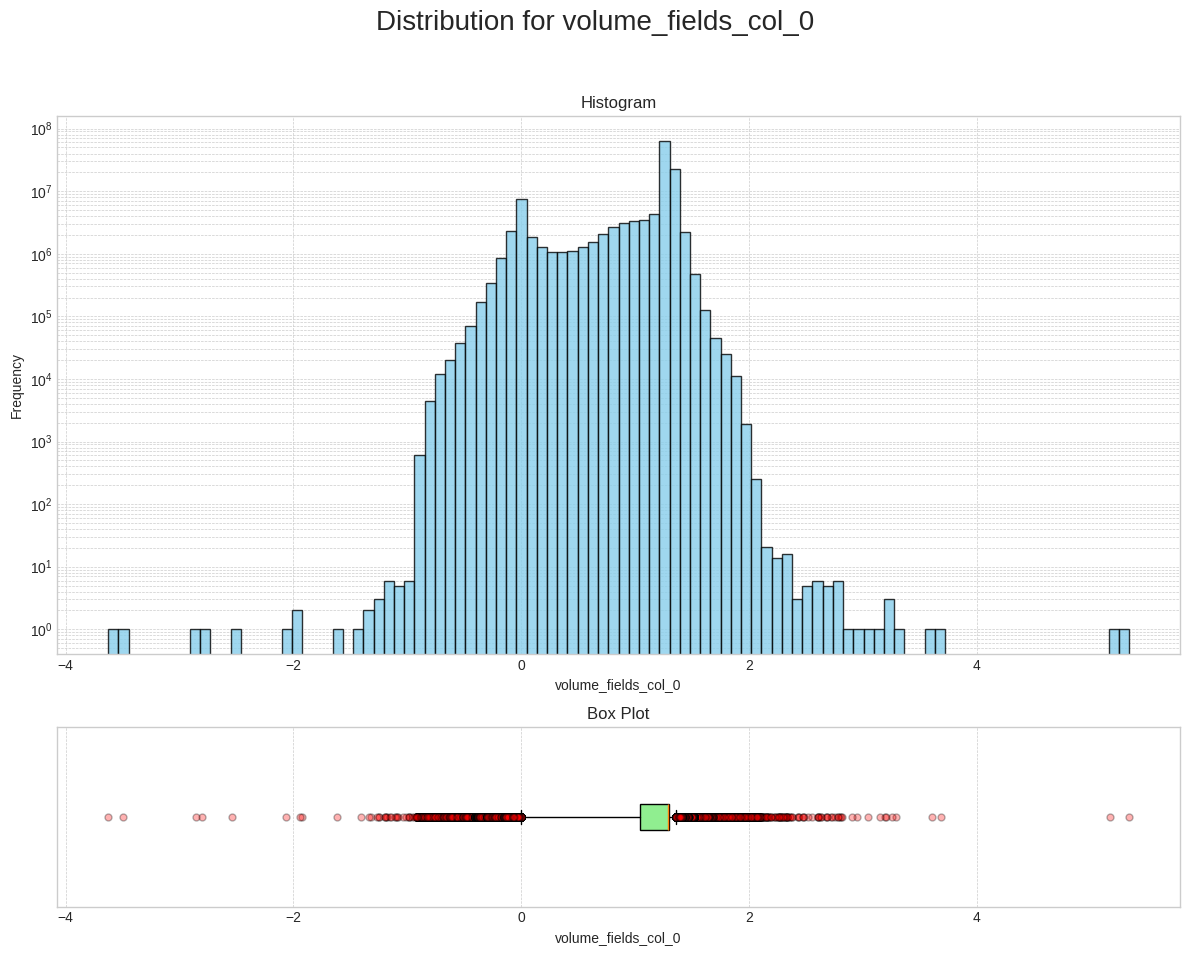


--------------- Analysis for: VOLUME_FIELDS_COL_1 ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: -1.8892
  Max: 3.4790
  Mean: -0.0012
  Std Dev: 0.0998

--- Percentile Distribution ---
   1th percentile: -0.3303
   5th percentile: -0.1222
  25th percentile: -0.0170
  50th percentile: 0.0000
  75th percentile: 0.0179
  95th percentile: 0.1121
  99th percentile: 0.3031
***************************************



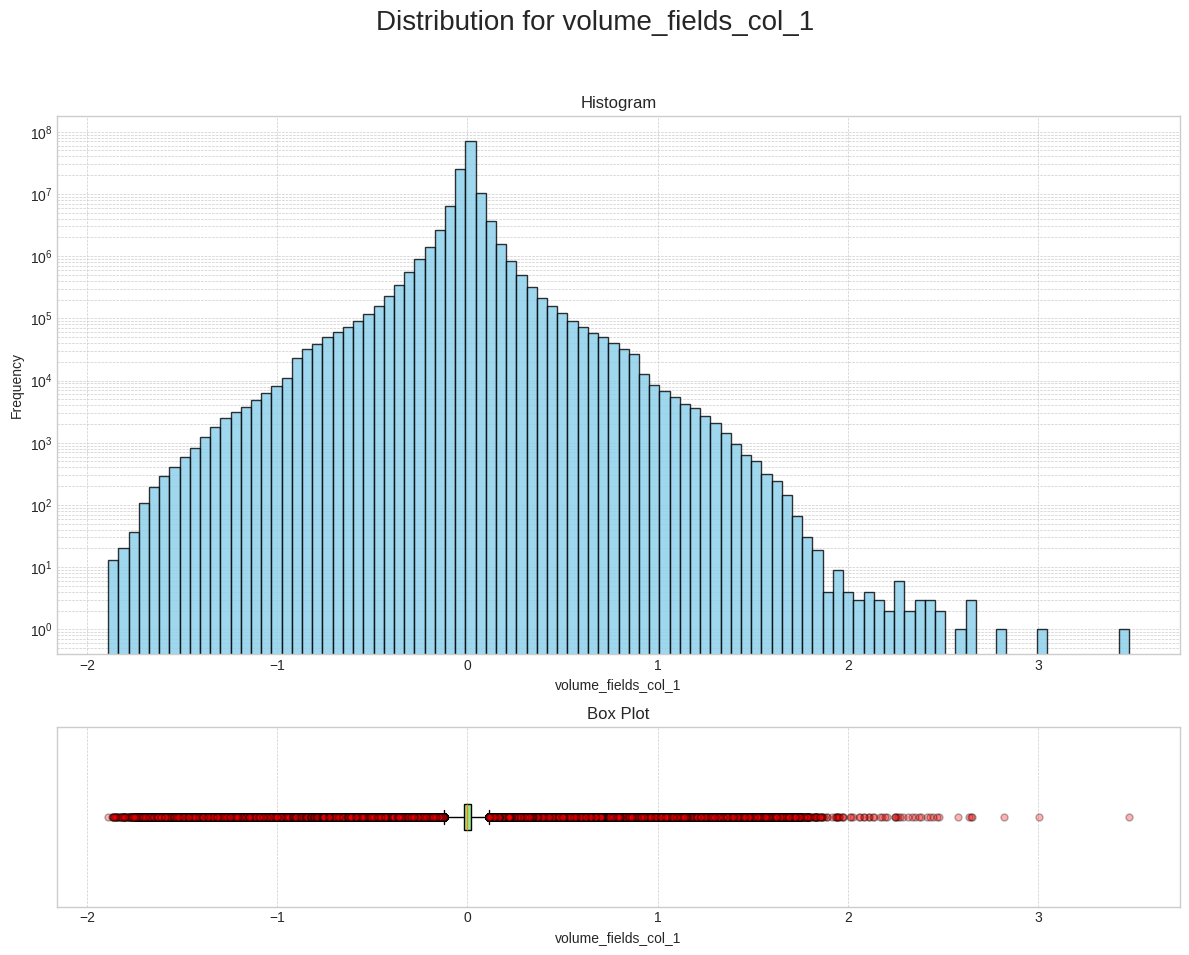


--------------- Analysis for: VOLUME_FIELDS_COL_2 ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: -2.5611
  Max: 2.7080
  Mean: 0.0073
  Std Dev: 0.1002

--- Percentile Distribution ---
   1th percentile: -0.2558
   5th percentile: -0.0960
  25th percentile: -0.0110
  50th percentile: 0.0005
  75th percentile: 0.0155
  95th percentile: 0.1223
  99th percentile: 0.4036
***************************************



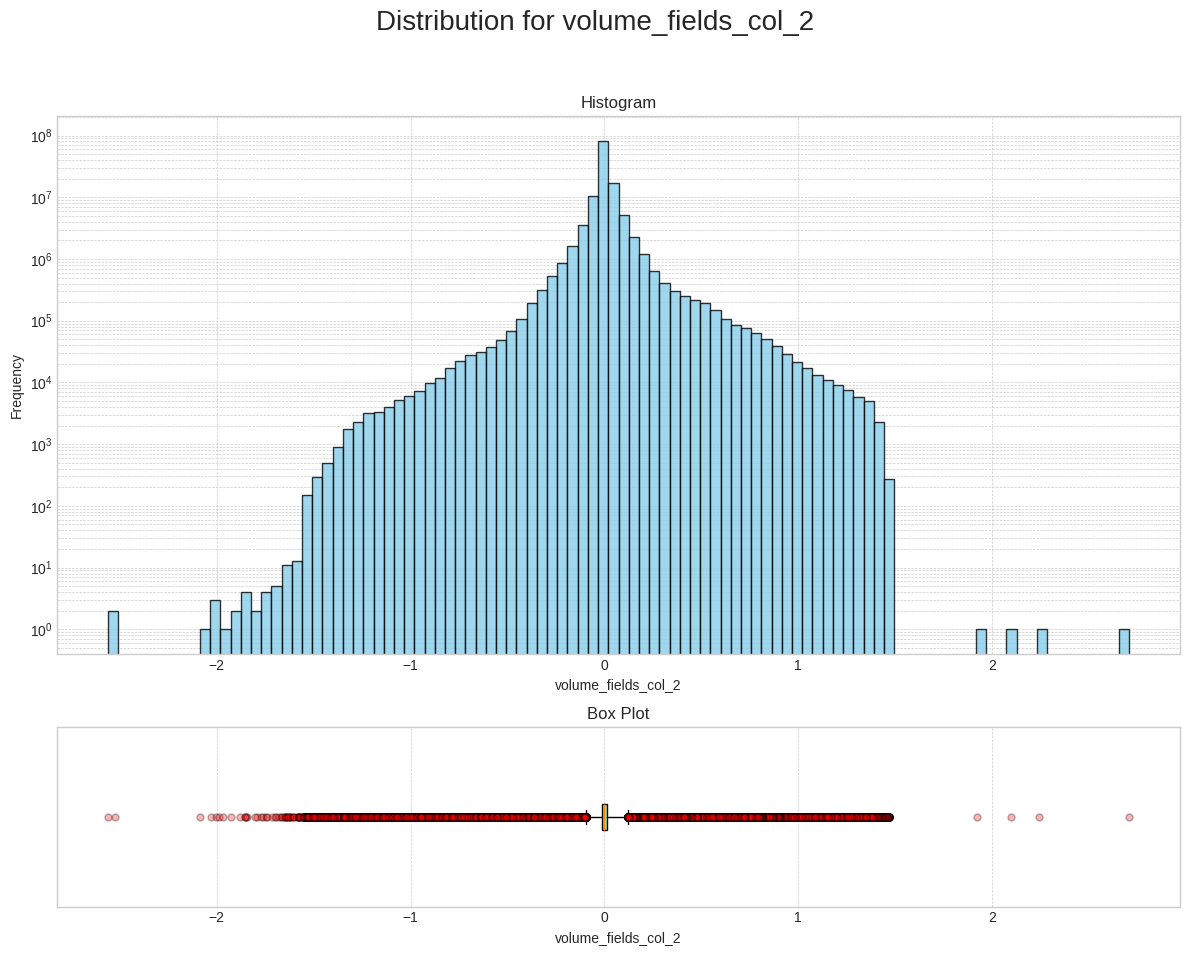


--------------- Analysis for: VOLUME_FIELDS_COL_3 ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: -28.5610
  Max: 7.8048
  Mean: -0.0240
  Std Dev: 0.0968

--- Percentile Distribution ---
   1th percentile: -0.3462
   5th percentile: -0.1856
  25th percentile: -0.0518
  50th percentile: 0.0037
  75th percentile: 0.0127
  95th percentile: 0.0492
  99th percentile: 0.2195
***************************************



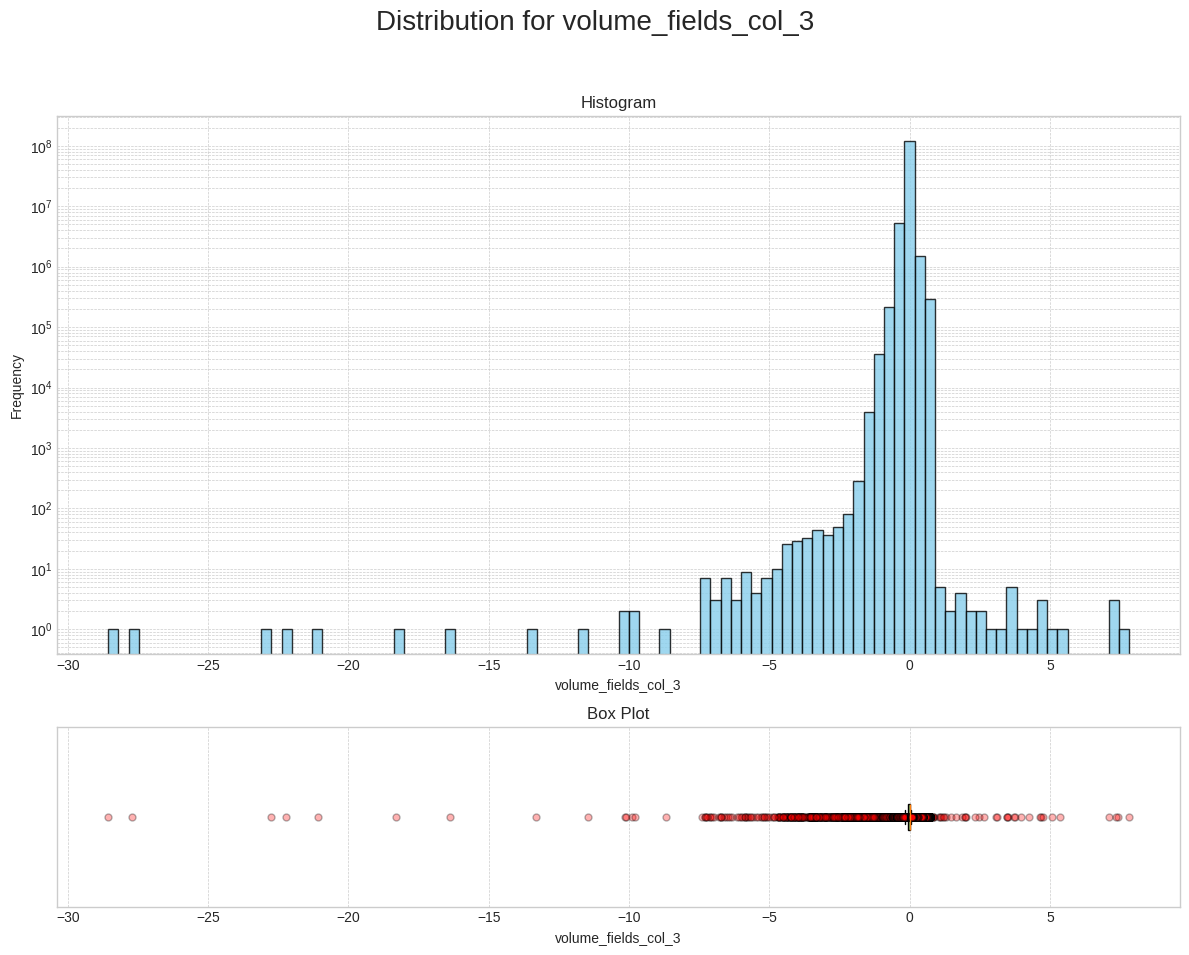


--------------- Analysis for: VOLUME_FIELDS_COL_4 ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: 0.0000
  Max: 0.0018
  Mean: 0.0004
  Std Dev: 0.0004

--- Percentile Distribution ---
   1th percentile: 0.0000
   5th percentile: 0.0000
  25th percentile: 0.0001
  50th percentile: 0.0002
  75th percentile: 0.0007
  95th percentile: 0.0009
  99th percentile: 0.0010
***************************************



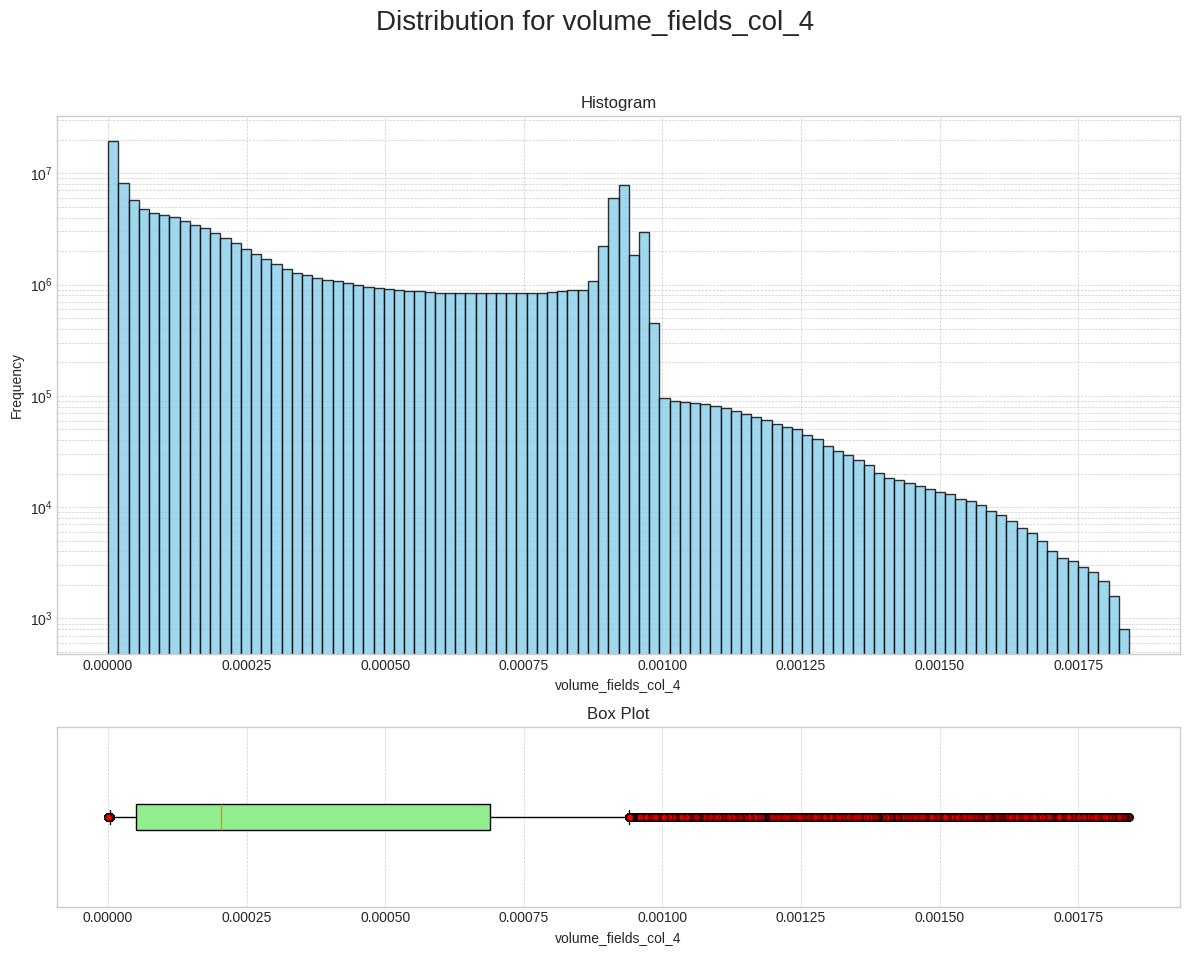


--------------- Analysis for: VOLUME_FIELDS_MAGNITUDE ---------------
Shape of aggregated data: (128581112,)
Total values calculated: 128581112
  Min: 0.0000
  Max: 6.4299
  Mean: 1.0948
  Std Dev: 0.3963

--- Percentile Distribution ---
   1th percentile: 0.0000
   5th percentile: 0.0935
  25th percentile: 1.0662
  50th percentile: 1.2896
  75th percentile: 1.2988
  95th percentile: 1.3654
  99th percentile: 1.4633
***************************************



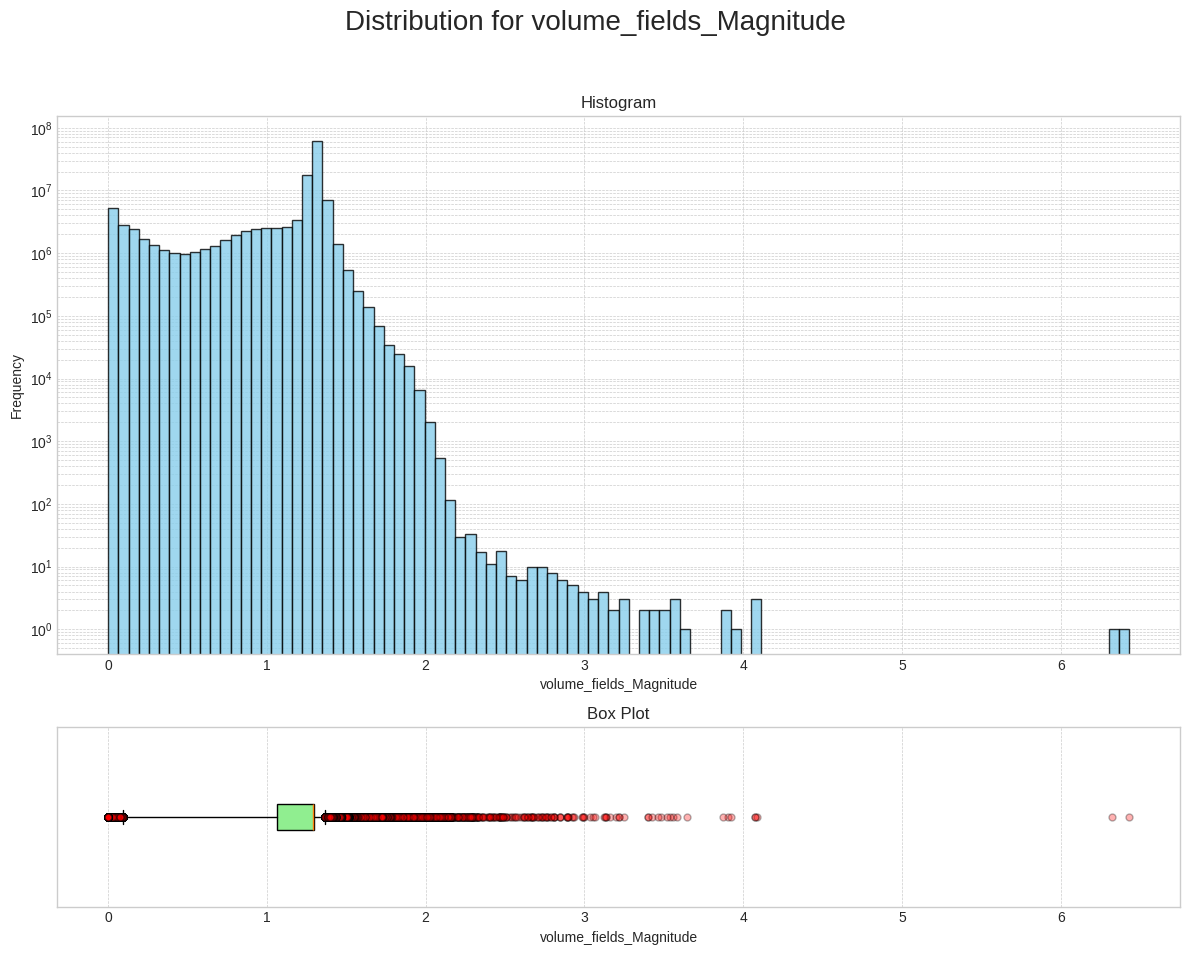


--------------- Analysis for: SURFACE_FIELDS_COL_0 ---------------
Shape of aggregated data: (2629867,)
Total values calculated: 2629867
  Min: -58.6741
  Max: 10.5289
  Mean: -0.1207
  Std Dev: 0.1982

--- Percentile Distribution ---
   1th percentile: -0.7470
   5th percentile: -0.3754
  25th percentile: -0.1807
  50th percentile: -0.1148
  75th percentile: -0.0694
  95th percentile: 0.1661
  99th percentile: 0.5672
***************************************



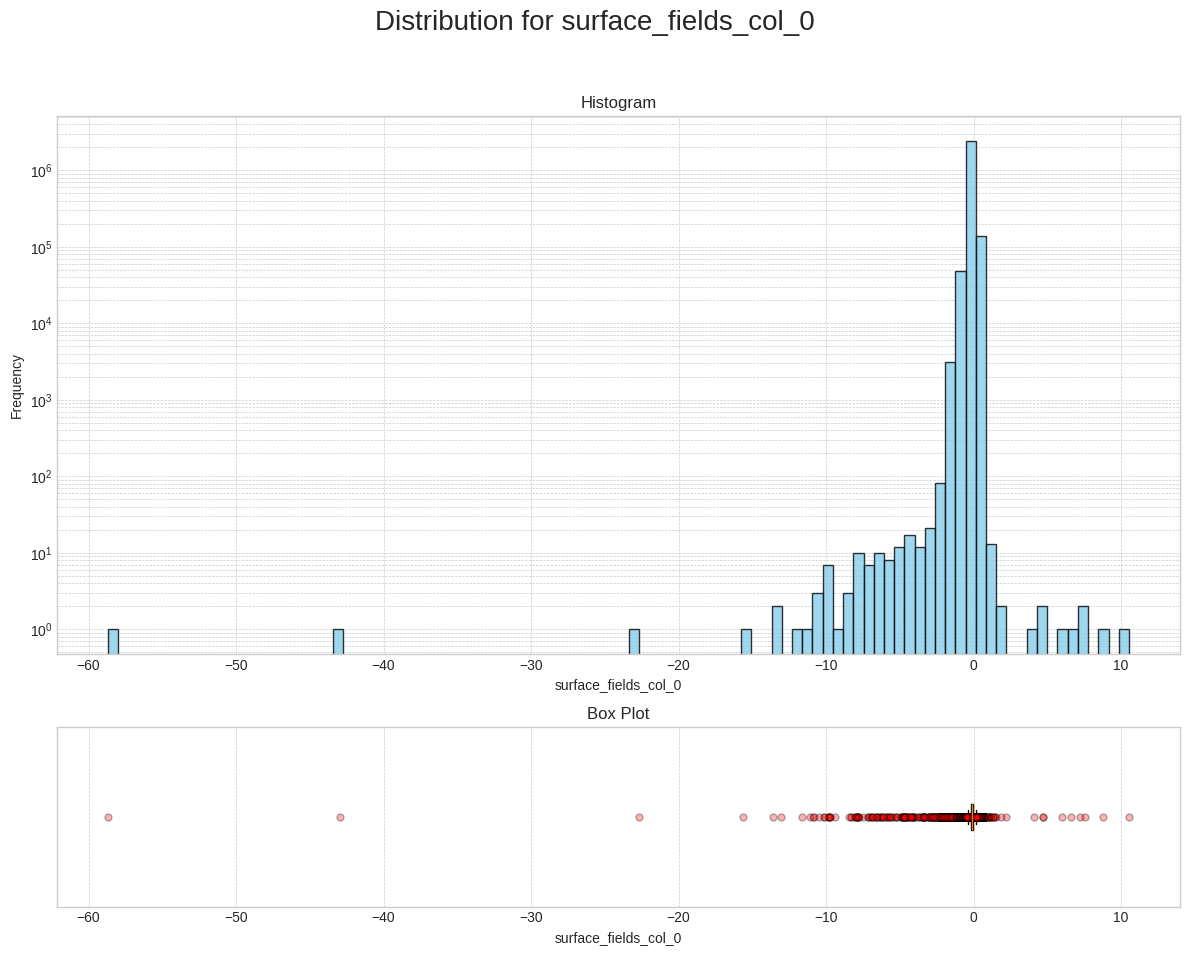


--------------- Analysis for: SURFACE_FIELDS_COL_1 ---------------
Shape of aggregated data: (2629867,)
Total values calculated: 2629867
  Min: -0.0315
  Max: 0.1164
  Mean: -0.0007
  Std Dev: 0.0010

--- Percentile Distribution ---
   1th percentile: -0.0036
   5th percentile: -0.0026
  25th percentile: -0.0013
  50th percentile: -0.0002
  75th percentile: 0.0000
  95th percentile: 0.0003
  99th percentile: 0.0010
***************************************



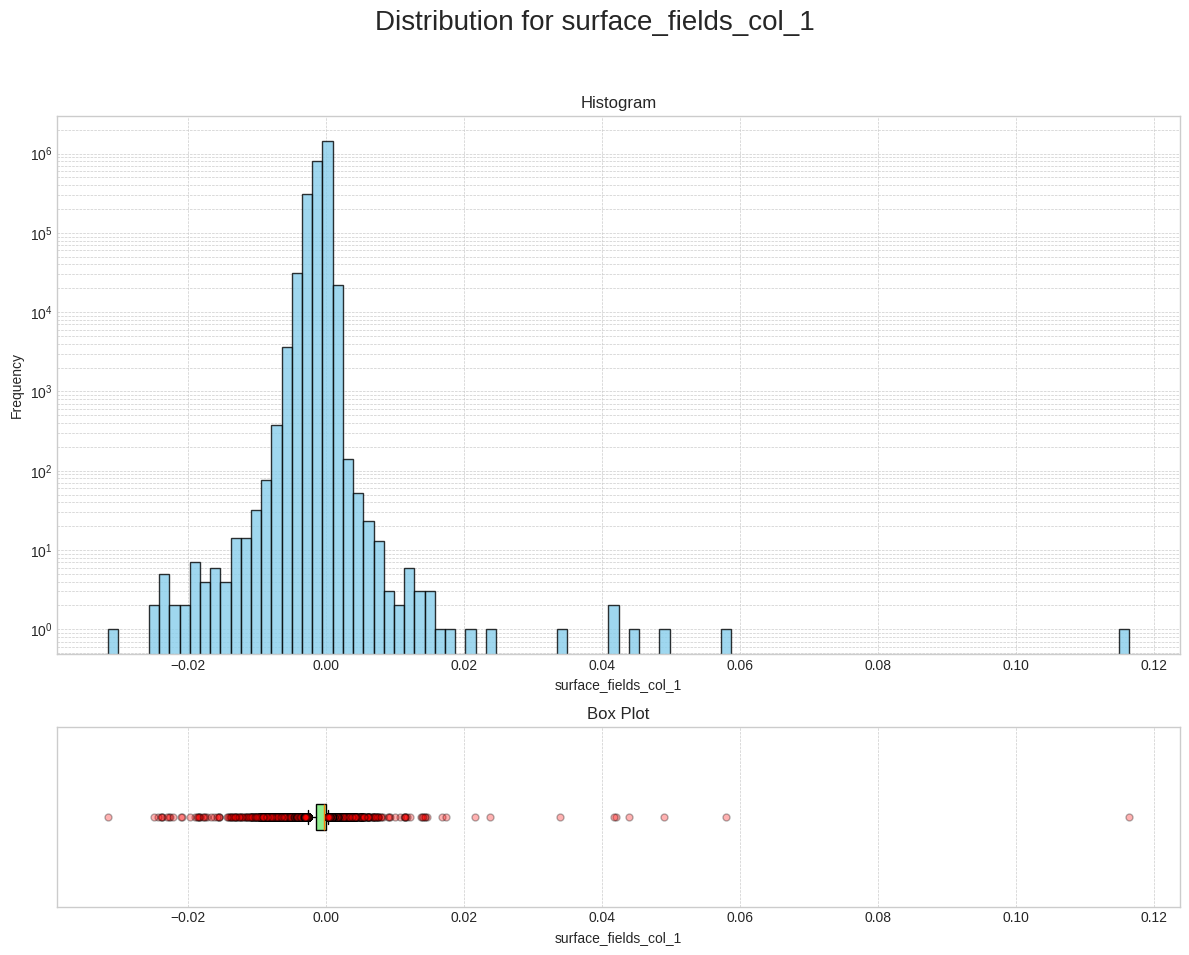


--------------- Analysis for: SURFACE_FIELDS_COL_2 ---------------
Shape of aggregated data: (2629867,)
Total values calculated: 2629867
  Min: -0.1143
  Max: 0.1005
  Mean: 0.0000
  Std Dev: 0.0005

--- Percentile Distribution ---
   1th percentile: -0.0015
   5th percentile: -0.0007
  25th percentile: -0.0001
  50th percentile: -0.0000
  75th percentile: 0.0001
  95th percentile: 0.0007
  99th percentile: 0.0015
***************************************



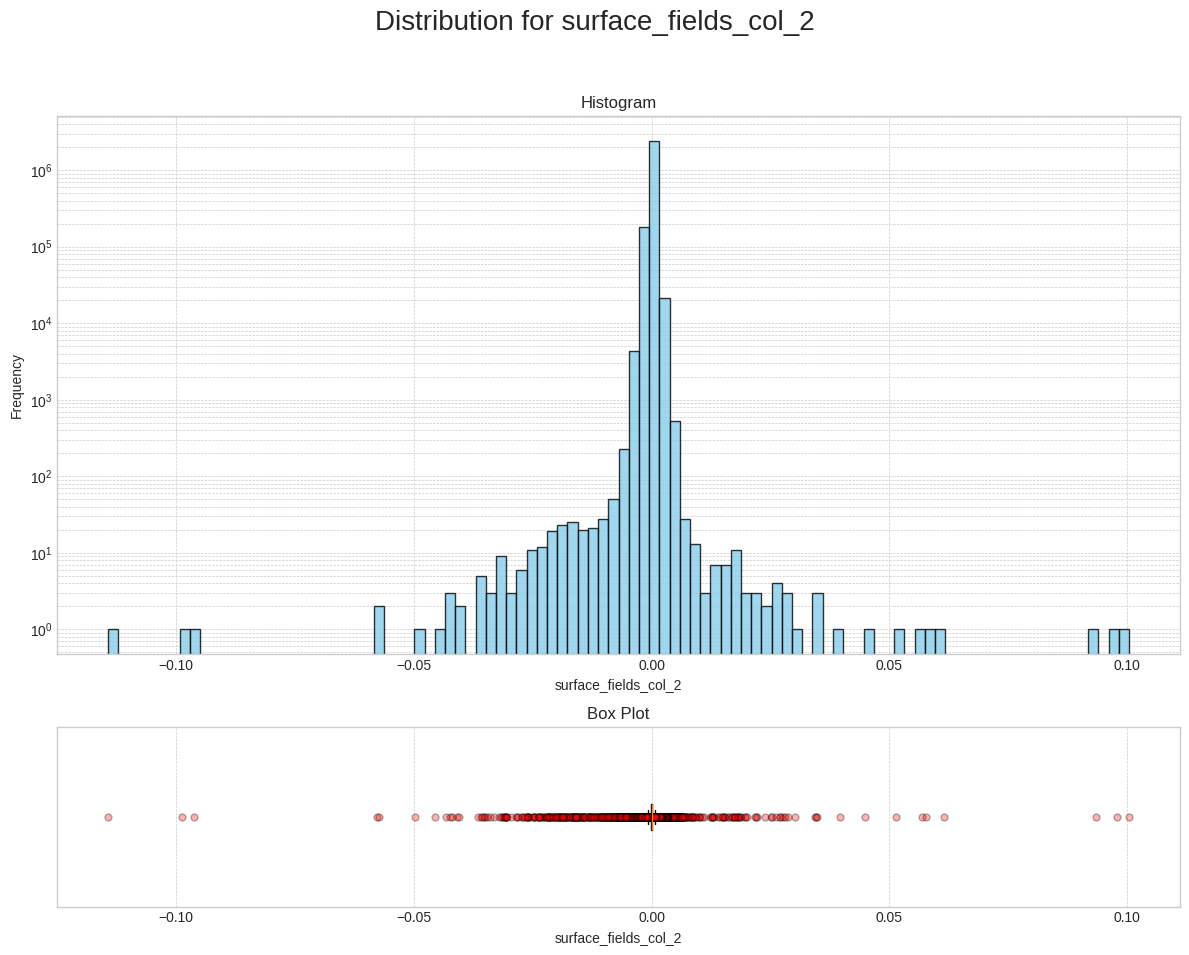


--------------- Analysis for: SURFACE_FIELDS_COL_3 ---------------
Shape of aggregated data: (2629867,)
Total values calculated: 2629867
  Min: -0.0278
  Max: 0.0573
  Mean: -0.0001
  Std Dev: 0.0006

--- Percentile Distribution ---
   1th percentile: -0.0025
   5th percentile: -0.0011
  25th percentile: -0.0002
  50th percentile: -0.0000
  75th percentile: 0.0001
  95th percentile: 0.0005
  99th percentile: 0.0013
***************************************



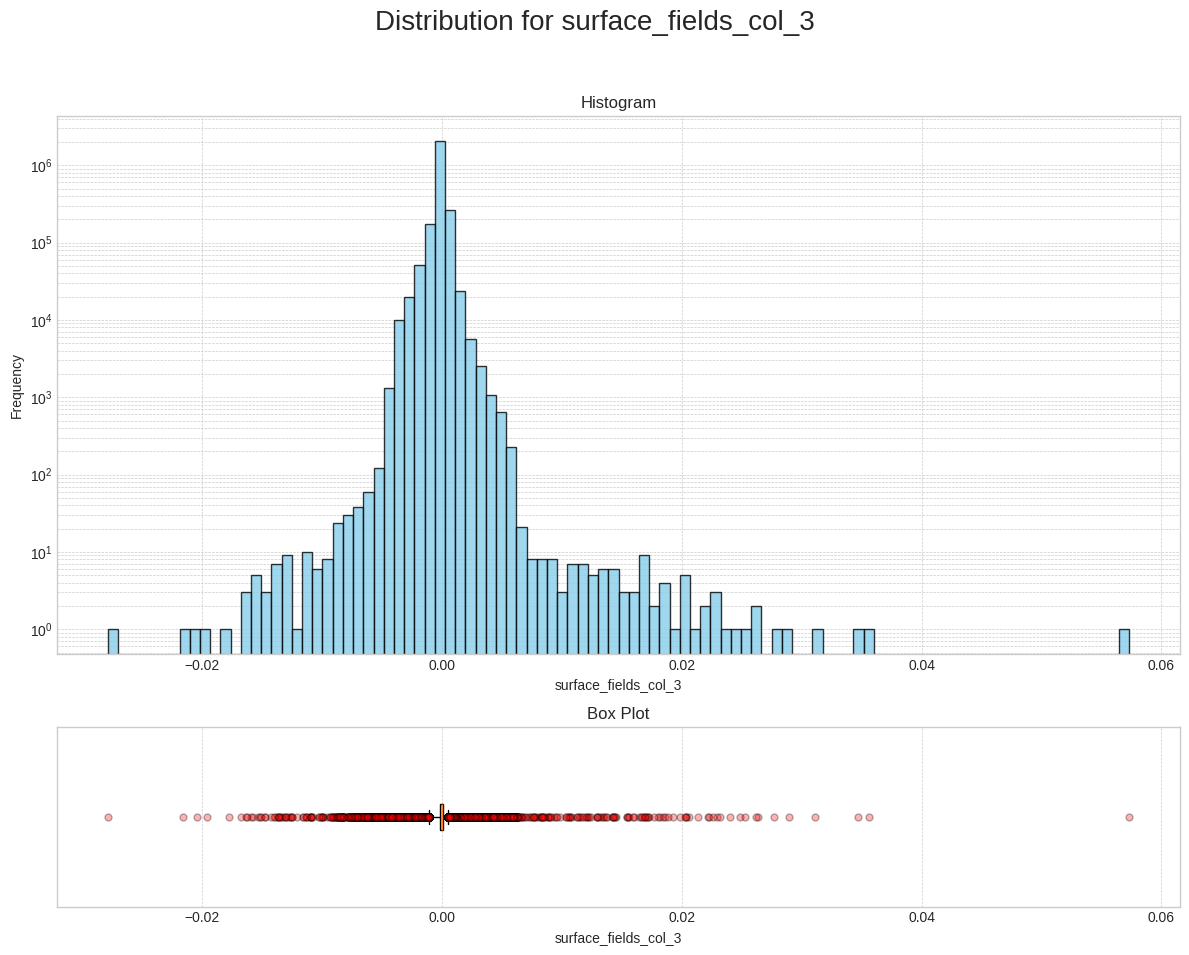

In [1]:
from utils import process_and_plot_directory

DATA_DIRECTORY = "/workspace/inst_dli/output_domino"
process_and_plot_directory(DATA_DIRECTORY)